In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

import pandas as pd

from sw_functions import download_sc_dataset, get_trajectory, bin_distance
from usefulfunc import fit_model, power_law, double_gaussian, gaussian, poisson

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1 hr resolution

In [2]:
# Get Mag / SW data
psp_mag, solo_mag = pd.read_pickle('data/psp_mag_rtn_1hour'), pd.read_pickle('data/solo_mag_rtn_1hour')
psp_sw, solo_sw = pd.read_pickle('data/psp_sweap_l3i_1hour'), pd.read_pickle('data/solo_swa_pas_grnd_mom_l2_1hour')

# Compute trajectory data
psp_traj_mag, psp_obstime_mag = get_trajectory(psp_mag, 'psp')
psp_traj_sw, psp_obstime_sw = get_trajectory(psp_sw, 'psp')

solo_traj_mag, solo_obstime_mag = get_trajectory(solo_mag, 'solo')
solo_traj_sw, solo_obstime_sw = get_trajectory(solo_sw, 'solo')

In [3]:
def create_ds(sc, year=None, years=None, dist_lim=None):
    """Create PSP or SolO complete dataset, global or by year.
    """
    if sc == 'psp':
        ds = psp_sw.join(psp_mag)
        ds['Distance'] = psp_traj_sw.radius.to('AU').value
        ds['lon'] = psp_traj_sw.lon.to('deg').value
        ds['lat'] = psp_traj_sw.lat.to('deg').value
        # Slice during Solo's Mission duration
        #start, end = '2020-4-15', '2025-5-31'
        #ds = ds[(ds.index >= start) & (ds.index <= end)]

    if sc == 'solo':
        ds = solo_sw.join(solo_mag)
        ds['Distance'] = solo_traj_sw.radius.to('AU').value
        ds['lon'] = solo_traj_sw.lon.to('deg').value
        ds['lat'] = solo_traj_sw.lat.to('deg').value

    if dist_lim:
        dist_min, dist_max = dist_lim
        ds = ds[(ds['Distance'] <= dist_max) & (ds['Distance'] >= dist_min)]

    if year:
        ds = ds[ds.index.year == year]

    if years:
        ds = ds[(ds.index.year >= years[0]) & (ds.index.year <= years[1])]

    return ds

Text(0.5, 0.91, 'SolO and PSP Distance/Latitude vs. Time Comparison')

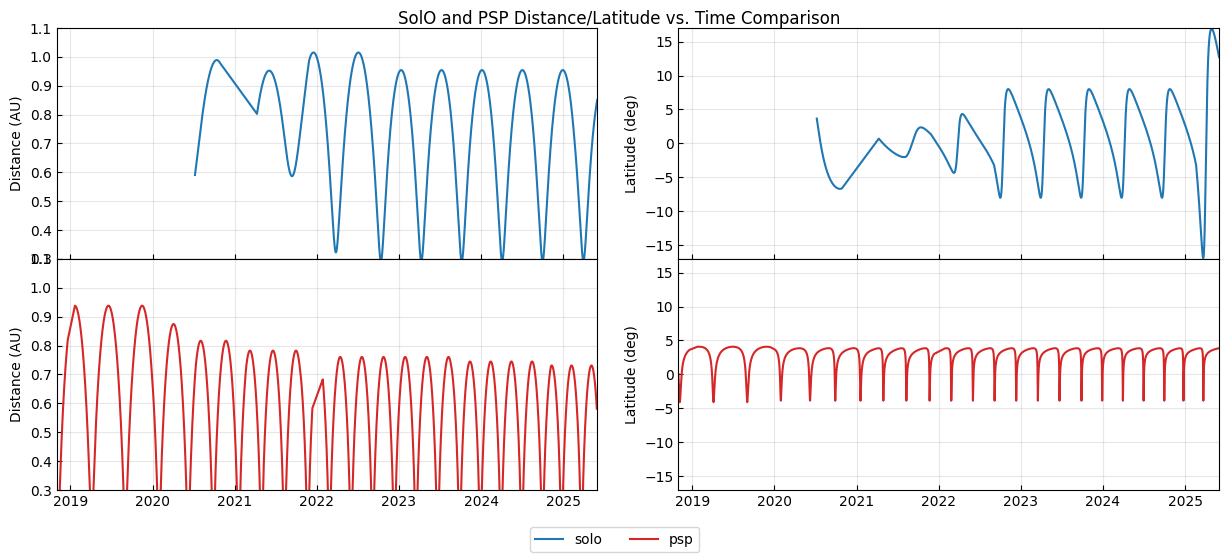

In [4]:
solo = create_ds('solo')
psp = create_ds('psp')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(15, 6))

ax1, ax2, ax3, ax4 = ax[0][0], ax[1][0], ax[0][1], ax[1][1]

dist_ylim = .3, 1.1
lat_ylim = -17, 17
psp_color = 'tab:red'
solo_color = 'tab:blue'

solo_dist = ax1.plot(solo['Distance'], c=solo_color, label='solo')
ax1.set_ylim(dist_ylim)
ax1.set_ylabel('Distance (AU)')

psp_dist = ax2.plot(psp['Distance'], c=psp_color, label='psp')
ax2.set_ylim(dist_ylim)
ax2.set_ylabel('Distance (AU)')

ax3.plot(solo['lat'], c=solo_color)
ax3.set_ylim(lat_ylim)
ax3.set_ylabel('Latitude (deg)')

ax4.plot(psp['lat'], c=psp_color)
ax4.set_ylim(lat_ylim)
ax4.set_ylabel('Latitude (deg)')

for aa in ax.flatten():
    aa.tick_params(axis='both', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)

#ax2.tick_params(axis='y', labelleft=False)
#ax4.tick_params(axis='y', labelleft=False)

plt.subplots_adjust(hspace=0, wspace=.15)
fig.legend(ncols=2, loc='lower center')
fig.suptitle('SolO and PSP Distance/Latitude vs. Time Comparison', y=.91)

In [5]:
# Find smallest delta in Distance and in Latitude between psp and solo
diff = (solo - psp).abs()

n = 10
#idx_dist = diff.nsmallest(n, 'Distance').index
idx_dist = diff.nsmallest(n, 'lon').index

# Do any match?
#print((idx_dist == idx_lat).any())

# Matches at
idx_match = idx_dist[-1]

solo.loc[idx_dist]['Distance'], psp.loc[idx_dist]['Distance'], solo.loc[idx_dist]['lat'], psp.loc[idx_dist]['lat']
#idx_match, solo.loc[idx_match]['Distance'], psp.loc[idx_match]['Distance'], solo.loc[idx_match]['lon'], psp.loc[idx_match]['lon']

(Epoch
 2022-04-06 10:00:00    0.395653
 2022-10-21 11:00:00    0.351118
 2021-09-18 20:00:00    0.592768
 2023-04-17 15:00:00    0.333546
 2021-09-18 21:00:00    0.592847
 2025-04-05 03:00:00    0.311293
 2021-11-19 19:00:00    0.944776
 2024-04-08 02:00:00    0.306770
 2021-08-11 19:00:00    0.706898
 2023-10-12 19:00:00    0.318255
 Name: Distance, dtype: float64,
 Epoch
 2022-04-06 10:00:00    0.745214
 2022-10-21 11:00:00    0.758691
 2021-09-18 20:00:00    0.757376
 2023-04-17 15:00:00    0.693094
 2021-09-18 21:00:00    0.757566
 2025-04-05 03:00:00    0.465066
 2021-11-19 19:00:00    0.110581
 2024-04-08 02:00:00    0.366297
 2021-08-11 19:00:00    0.129208
 2023-10-12 19:00:00    0.492753
 Name: Distance, dtype: float64,
 Epoch
 2022-04-06 10:00:00    3.651860
 2022-10-21 11:00:00    4.831494
 2021-09-18 20:00:00    1.381625
 2023-04-17 15:00:00    3.773454
 2021-09-18 21:00:00    1.385106
 2025-04-05 03:00:00    0.869788
 2021-11-19 19:00:00    1.589596
 2024-04-08 02:00:00  

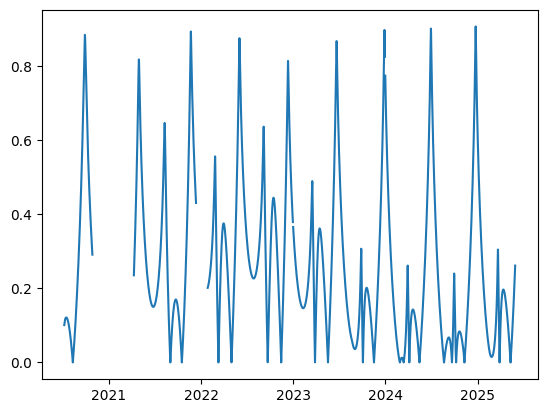

In [6]:
plt.plot(diff['Distance'])
#plt.scatter(idx_match, diff.loc[idx_match]['Distance'], c='r')

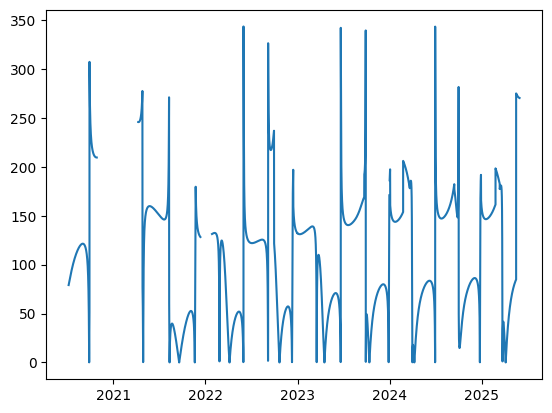

In [7]:
plt.plot(diff['lon'])
#plt.scatter(idx_match, diff.loc[idx_match]['lat'], c='r')

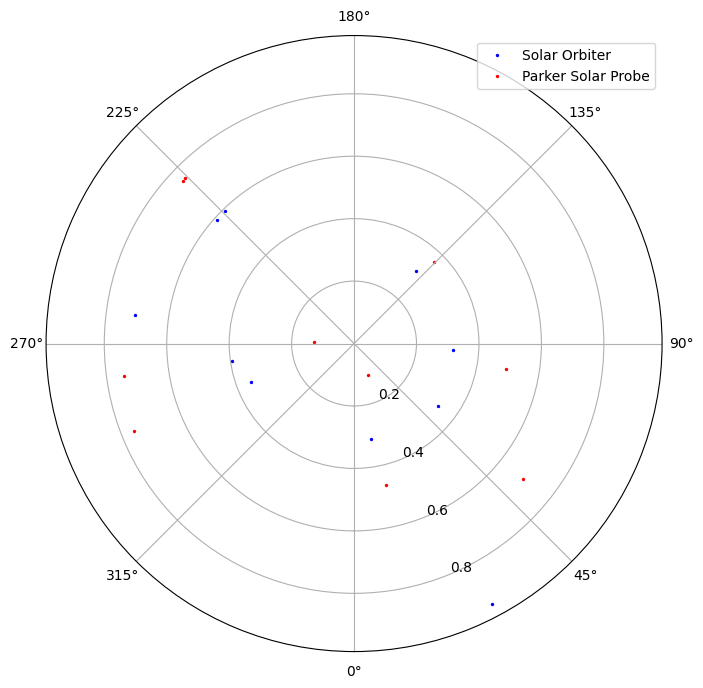

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='polar')
im = ax.scatter(solo.loc[idx_dist]['lon'], solo.loc[idx_dist]['Distance'], s=2, label="Solar Orbiter", c='blue')
im2 = ax.scatter(psp.loc[idx_dist]['lon'], psp.loc[idx_dist]['Distance'], s=2, label="Parker Solar Probe", c='r')

ax.set_theta_zero_location("S")
plt.legend()
plt.show()

# High resolution
2024-04-08 02:00:00

Import High resolution data

In [10]:
# Get Mag / SW data
psp_mag_res, solo_mag_res = pd.read_pickle('data/psp_mag_rtn_1min'), pd.read_pickle('data/solo_mag_rtn_1min')
psp_sw_res, solo_sw_res = pd.read_pickle('data/psp_sweap_l3i_30sec'), pd.read_pickle('data/solo_swa_pas_grnd_mom_l2_4sec')

Subselect High resolution data and obtain trajectory

In [86]:
start = '2024-04-07 00:00'
stop = '2024-04-10 00:00'

psp_mag_sub = psp_mag_res[(psp_mag_res.index <= stop) &  (psp_mag_res.index >= start)]
psp_sw_sub = psp_sw_res[(psp_sw_res.index <= stop) &  (psp_sw_res.index >= start)]
solo_mag_sub = solo_mag_res[(solo_mag_res.index <= stop) &  (solo_mag_res.index >= start)]
solo_sw_sub = solo_sw_res[(solo_sw_res.index <= stop) &  (solo_sw_res.index >= start)]

In [87]:
solo_traj, _ = get_trajectory(solo_sw_sub, 'solo')
psp_traj, _ = get_trajectory(solo_sw_sub, 'psp')

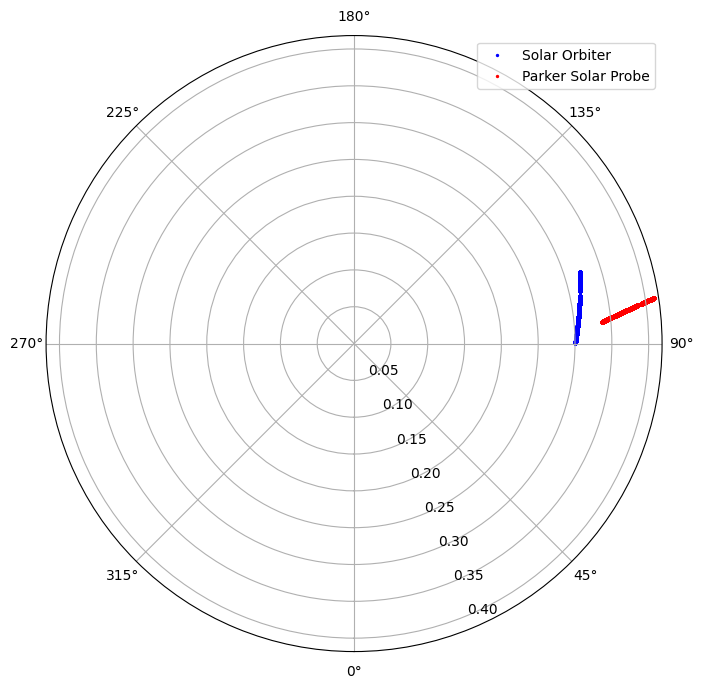

In [88]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='polar')
im = ax.scatter(solo_traj.lon.to('rad'), solo_traj.radius.to('AU'), s=2, label="Solar Orbiter", c='blue')
im2 = ax.scatter(psp_traj.lon.to('rad'), psp_traj.radius.to('AU'), s=2, label="Parker Solar Probe", c='r')

ax.set_theta_zero_location("S")
plt.legend()
plt.show()

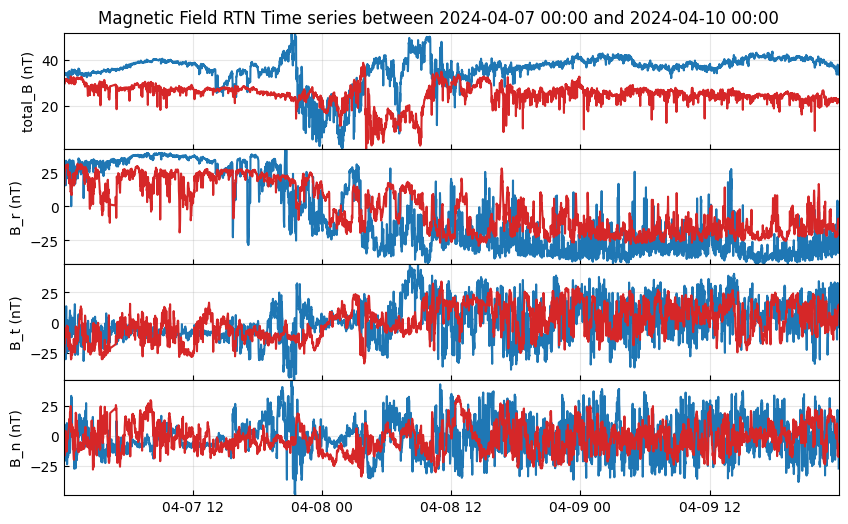

In [ ]:
fig, ax = plt.subplots(4, figsize=(10,6))

for aa, param in zip(ax.flatten(), ['total_B', 'B_r', 'B_t', 'B_n']):
    aa.plot(solo_mag_sub[f'{param}'], c='tab:blue')
    aa.plot(psp_mag_sub[f'{param}'].dropna(), c='tab:red')
    aa.set_ylabel(f'{param} (nT)')

    aa.tick_params(axis='both', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)

fig.suptitle(f'Magnetic Field RTN Time series between {start} and {stop}', y=.92)
fig.legend()
plt.subplots_adjust(hspace=0, wspace=.15)

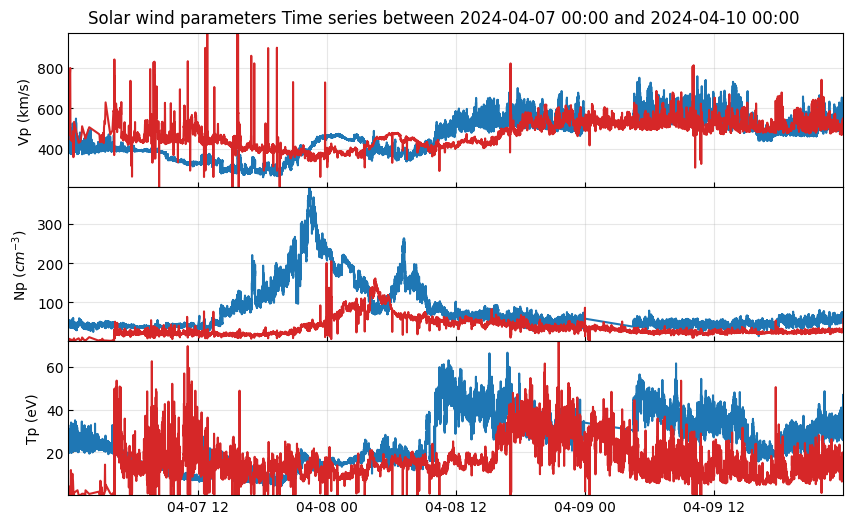

In [90]:
fig, ax = plt.subplots(3, figsize=(10,6))

for aa, param, unit in zip(ax.flatten(), ['Vp', 'Np', 'Tp'], ['km/s', '$cm^{-3}$', 'eV']):
    aa.plot(solo_sw_sub[f'{param}'], c='tab:blue')
    aa.plot(psp_sw_sub[f'{param}'].dropna(), c='tab:red')
    aa.set_ylabel(f'{param} ({unit})')

    aa.tick_params(axis='both', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)

#ax2.tick_params(axis='y', labelleft=False)
#ax4.tick_params(axis='y', labelleft=False)

fig.suptitle(f'Solar wind parameters Time series between {start} and {stop}', y=.92)
plt.subplots_adjust(hspace=0, wspace=.15)

/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_14422/756745447.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_14422/756745447.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_14422/756745447.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


KeyboardInterrupt: 

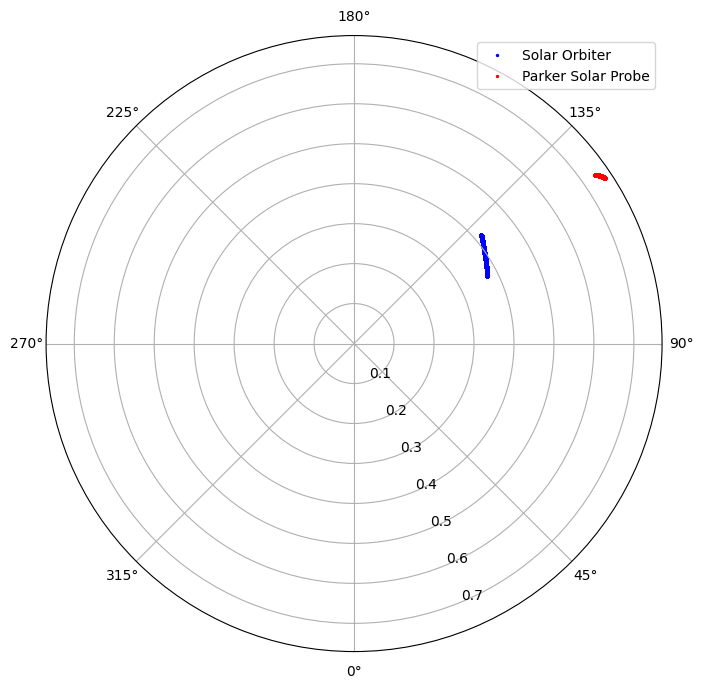

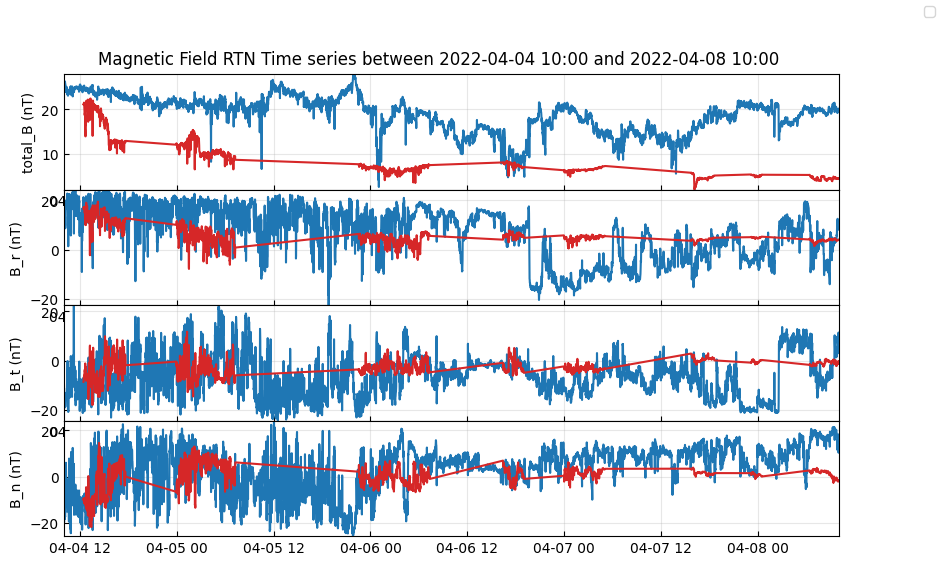

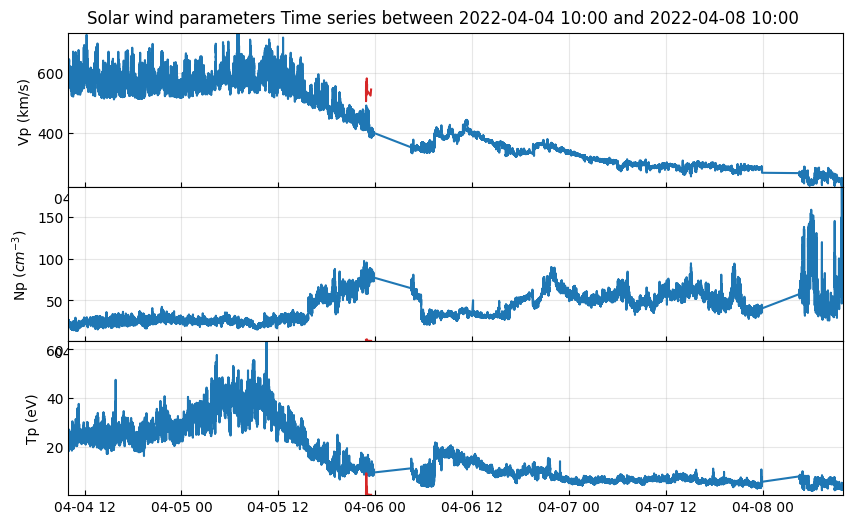

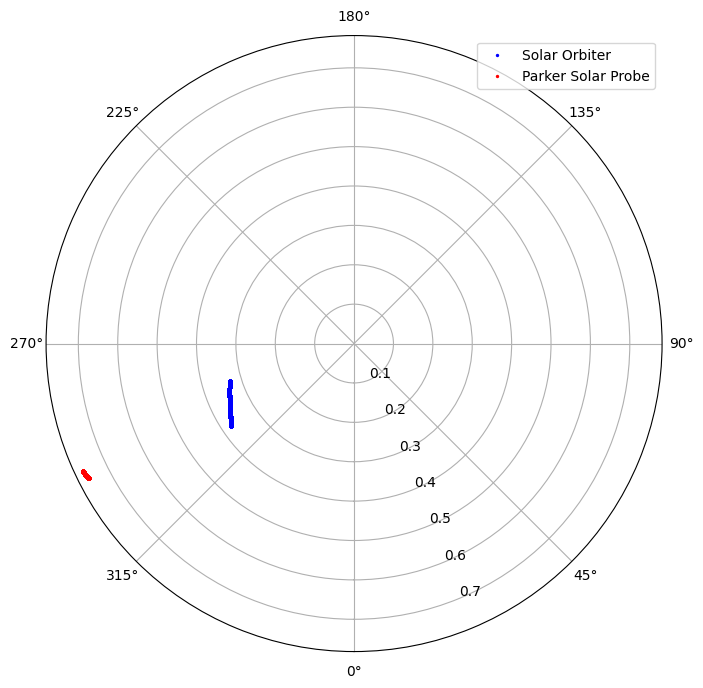

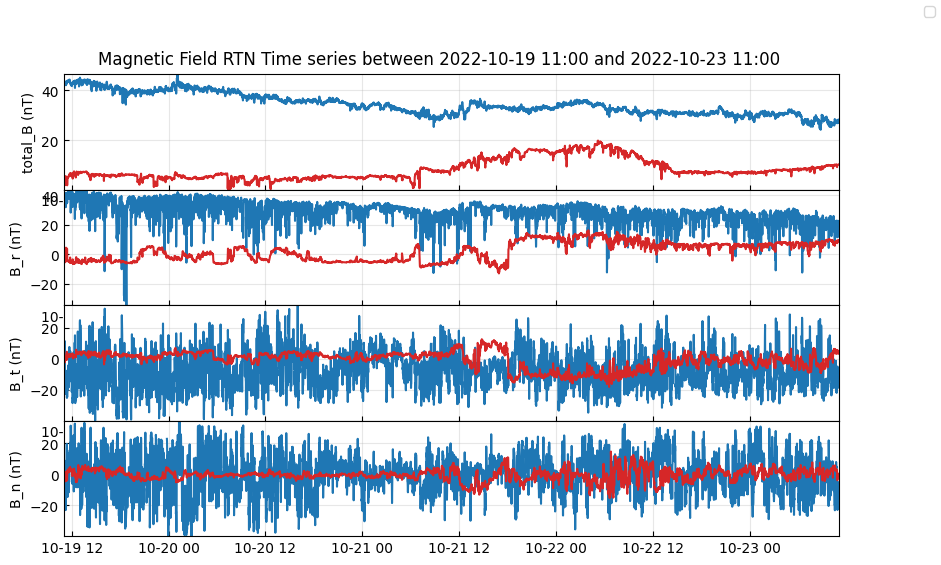

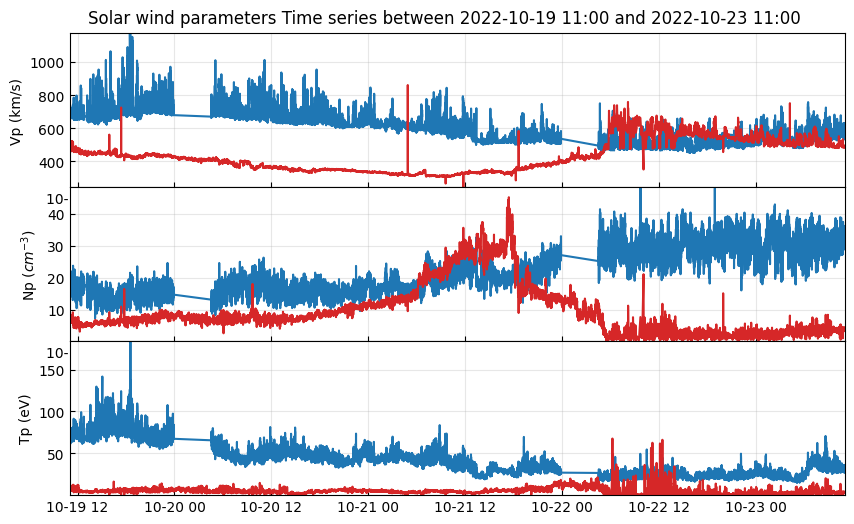

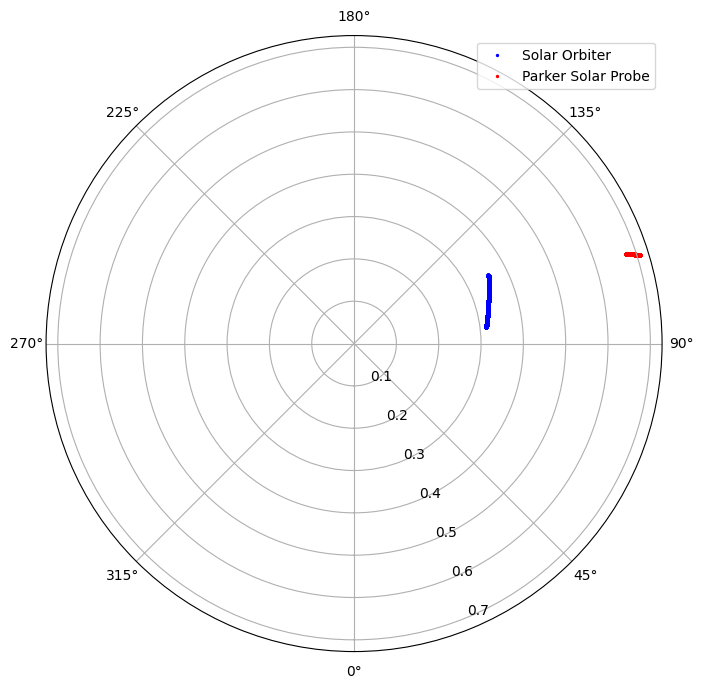

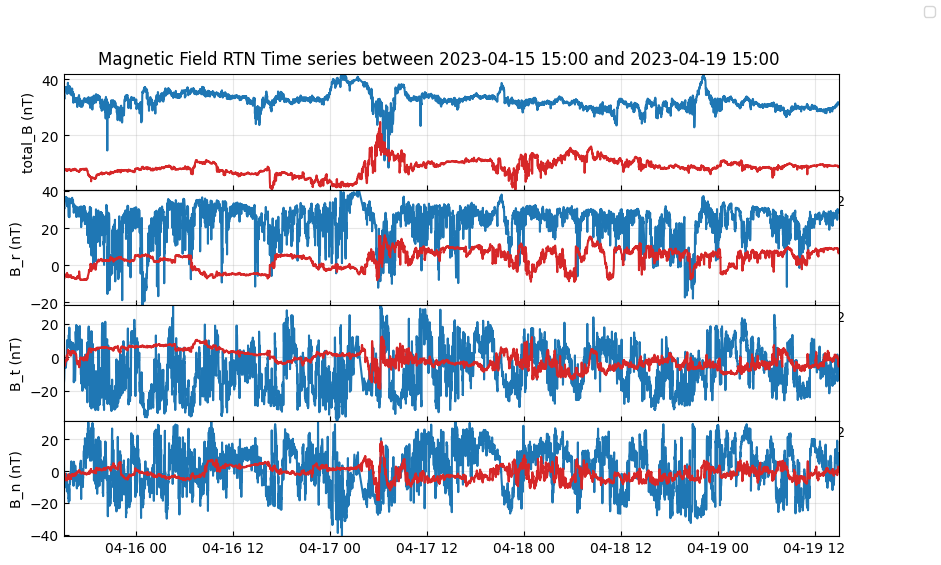

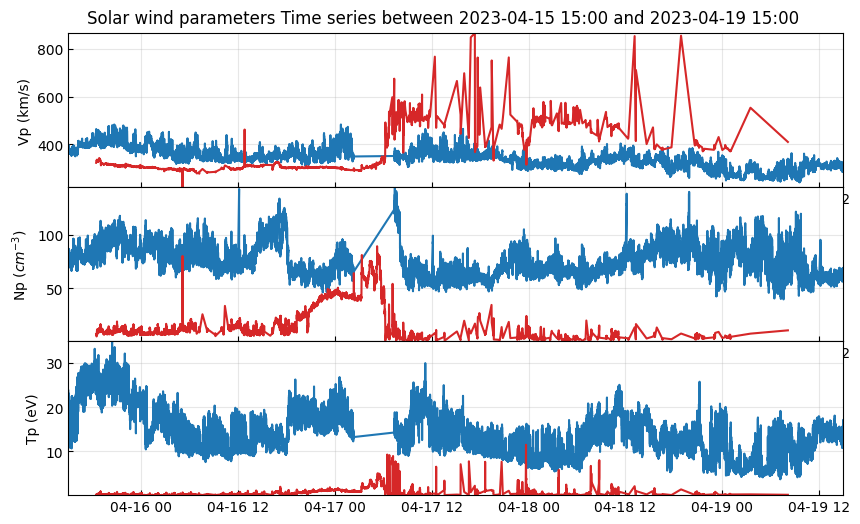

In [122]:
starts, stops = np.delete(idx_dist, [2, 4]) - np.timedelta64(2, 'D'), np.delete(idx_dist, [2, 4]) + np.timedelta64(2, 'D')

starts_str = starts.strftime('%Y-%m-%d %H:%M')
stops_str = stops.strftime('%Y-%m-%d %H:%M')

for start, stop in zip(starts_str, stops_str):
    
    # Subselect data
    psp_mag_sub = psp_mag_res[(psp_mag_res.index <= stop) &  (psp_mag_res.index >= start)]
    psp_sw_sub = psp_sw_res[(psp_sw_res.index <= stop) &  (psp_sw_res.index >= start)]
    solo_mag_sub = solo_mag_res[(solo_mag_res.index <= stop) &  (solo_mag_res.index >= start)]
    solo_sw_sub = solo_sw_res[(solo_sw_res.index <= stop) &  (solo_sw_res.index >= start)]

    # Select traj
    solo_traj, _ = get_trajectory(solo_sw_sub, 'solo')
    psp_traj, _ = get_trajectory(solo_sw_sub, 'psp')

    # Show traj
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='polar')
    im = ax.scatter(solo_traj.lon.to('rad'), solo_traj.radius.to('AU'), s=2, label="Solar Orbiter", c='blue')
    im2 = ax.scatter(psp_traj.lon.to('rad'), psp_traj.radius.to('AU'), s=2, label="Parker Solar Probe", c='r')

    ax.set_theta_zero_location("S")
    plt.legend()

    # MAG-RTN Timeseries
    fig, ax = plt.subplots(4, figsize=(10,6))

    for aa, param in zip(ax.flatten(), ['total_B', 'B_r', 'B_t', 'B_n']):
        aa.plot(solo_mag_sub[f'{param}'], c='tab:blue')
        aa.plot(psp_mag_sub[f'{param}'].dropna(), c='tab:red')
        aa.set_ylabel(f'{param} (nT)')

        aa.tick_params(axis='both', direction='in')
        aa.margins(x=0, y=0)
        aa.grid('.', alpha=0.3)

    fig.suptitle(f'Magnetic Field RTN Time series between {start} and {stop}', y=.92)
    fig.legend()
    plt.subplots_adjust(hspace=0, wspace=.15)

    # Solar wind parameters timeseries
    fig, ax = plt.subplots(3, figsize=(10,6))

    for aa, param, unit in zip(ax.flatten(), ['Vp', 'Np', 'Tp'], ['km/s', '$cm^{-3}$', 'eV']):
        aa.plot(solo_sw_sub[f'{param}'], c='tab:blue')
        aa.plot(psp_sw_sub[f'{param}'].dropna(), c='tab:red')
        aa.set_ylabel(f'{param} ({unit})')

        aa.tick_params(axis='both', direction='in')
        aa.margins(x=0, y=0)
        aa.grid('.', alpha=0.3)

    #ax2.tick_params(axis='y', labelleft=False)
    #ax4.tick_params(axis='y', labelleft=False)

    fig.suptitle(f'Solar wind parameters Time series between {start} and {stop}', y=.92)
    plt.subplots_adjust(hspace=0, wspace=.15)